In [1]:

import numpy as np
from scipy.signal import resample

# Load the data
#avg_entries = np.load("../../../sca101/generators/new_entries1.npy")
#subset_traces = np.load("../../../sca101/generators/averaged_traces1000-0.793281.npy")
avg_entries = np.load("destination/folder/var_0/inputs.npy")
subset_traces = np.load("destination/folder/var_0/traces.npy")
#avg_entries = np.load("avg_entries.npy")
#subset_traces = np.load("avg_traces.npy")
# Select 50 inputs and their corresponding traces without limiting the number of points
selected_avg_entries = avg_entries[:1000]
selected_subset_traces = subset_traces[:1000]

# Resample the traces to 5000 points
#resampled_subset_traces = resample(selected_subset_traces, 100000, axis=1)

# Data cleaning: Remove NaN and extreme values

# Remove NaN values from selected_avg_entries
nan_indices = np.argwhere(np.isnan(selected_avg_entries))
cleaned_avg_entries = np.delete(selected_avg_entries, nan_indices, axis=0)

# Remove corresponding traces
cleaned_subset_traces = np.delete(selected_subset_traces, nan_indices, axis=0)




In [13]:
avg_entries

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [2]:

import struct
import math

 


filtered_exhaustive_hypotheses = np.arange(0.0, 5.01, 0.01)

 


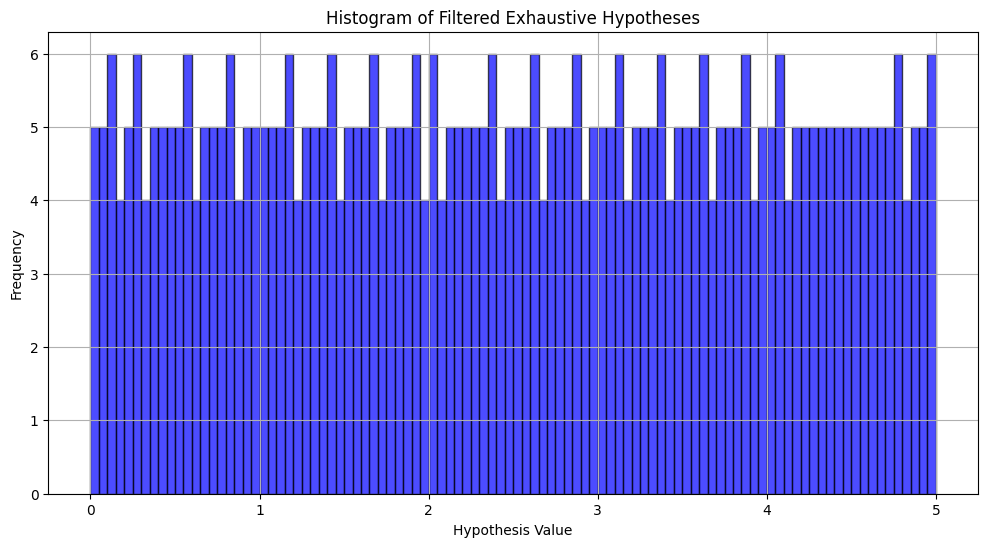

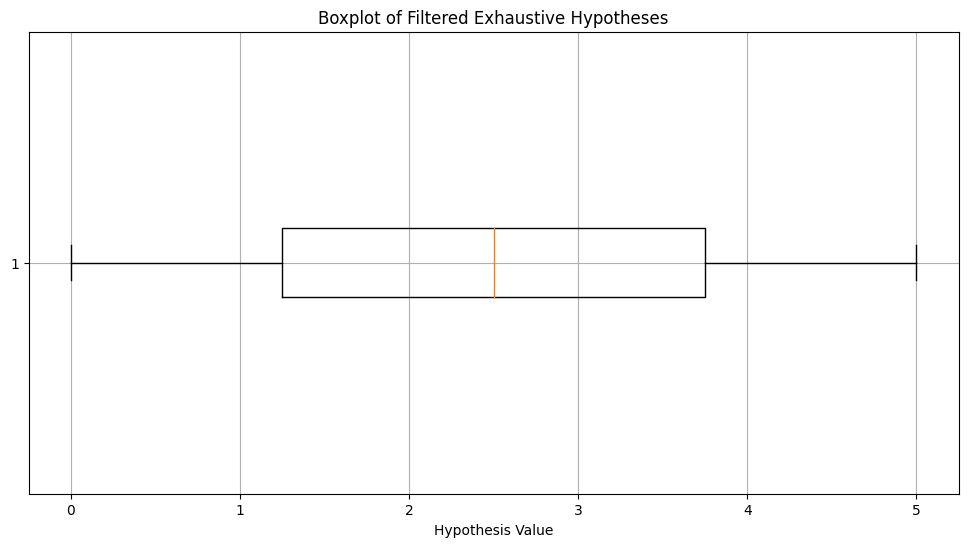

In [3]:
# Importing matplotlib for plotting
import matplotlib.pyplot as plt

# Generate the histogram for the filtered exhaustive hypotheses
plt.figure(figsize=(12, 6))
plt.hist(filtered_exhaustive_hypotheses, bins=100, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of Filtered Exhaustive Hypotheses')
plt.xlabel('Hypothesis Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Generate a boxplot to show the range and outliers
plt.figure(figsize=(12, 6))
plt.boxplot(filtered_exhaustive_hypotheses, vert=False)
plt.title('Boxplot of Filtered Exhaustive Hypotheses')
plt.xlabel('Hypothesis Value')
plt.grid(True)
plt.show()



In [4]:
# ------------------------ Hamming Weight functions ------------------------ #

_HW8_table = np.array([bin(x).count('1') for x in range(256)], dtype = np.uint8)

def hamming_weight_8(x):
    return _HW8_table[x]

def hamming_weight_16(x):
    return hamming_weight_8(x & 0xFF) + hamming_weight_8(x >> 8)

def hamming_weight_32(x):
    return hamming_weight_16(x & 0xFFFF) + hamming_weight_16(x >> 16)

def hamming_weight_64(x):
    return hamming_weight_32(x & 0xFFFFFFFF) + hamming_weight_32(x >> 32)

def HW_IEEE754(x):
    return hamming_weight_32(x)

def local_HW_IEEE754(x, decalage):
    return hamming_weight_32(x >> decalage)

def hamming_weight(x):
    return bin(x).count('1')

def mean(X):
    return np.sum(X, axis=0) / len(X)

def std_dev(X, X_bar):
    return np.sqrt(np.sum((X - X_bar) ** 2, axis=0) / len(X))

def cov(X, X_bar, Y, Y_bar):
    return np.sum((X - X_bar) * (Y - Y_bar), axis=0) / len(X)

def HW_of_product(entry, hypothesis):
    product = entry * hypothesis
    return hamming_weight_32(struct.unpack('!I', struct.pack('!f', product))[0])

<IPython.core.display.Javascript object>


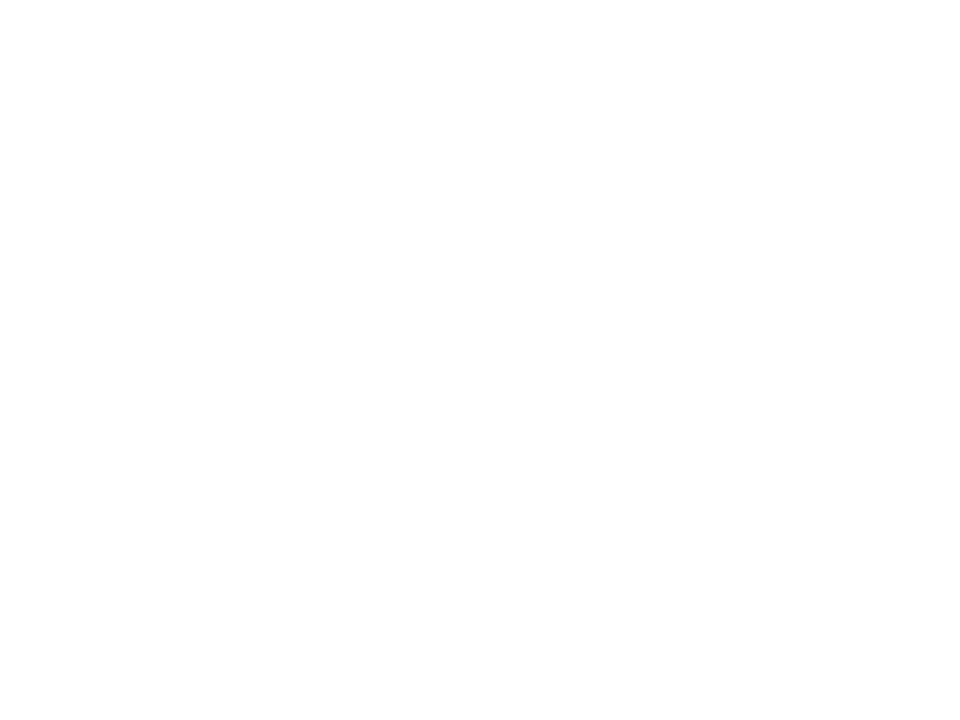

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\zqde8\AppData\Local\Temp\ipykernel_3252\1377020126.py:56: RuntimeWarning: invalid value encountered in divide
  cpaoutput = correlation / (std_t * std_hws)


In [5]:
%matplotlib notebook
from tqdm.notebook import trange
import numpy as np
import struct
import matplotlib.pyplot as plt


# Initialize variables
num_hypothesis = len(filtered_exhaustive_hypotheses)
max_correlations = np.zeros(num_hypothesis)

# Initialize variables to hold incremental statistics
total_count = 0
running_t_bar = 0
running_o_t = 0
running_hws_bar = np.zeros(num_hypothesis)
running_o_hws = np.zeros(num_hypothesis)

# Initialize plot
plt.ion()
fig, ax = plt.subplots()
ax.set_xlim(min(filtered_exhaustive_hypotheses), max(filtered_exhaustive_hypotheses))
ax.set_ylim(-1, 1)
plt.xlabel('Hypothesis Values')
plt.ylabel('Max Correlation')
plt.title('Real-time Max Correlation for Different Hypotheses')

# Loop over each chunk of data
for chunk_start in trange(0, len(cleaned_avg_entries), 10):
    chunk_end = min(chunk_start + 10, len(cleaned_avg_entries))
    traces_chunk = cleaned_subset_traces[chunk_start:chunk_end]
    entries_chunk = cleaned_avg_entries[chunk_start:chunk_end]
    
    total_count += len(traces_chunk)
    
    # Update running statistics for traces
    delta_t = traces_chunk - running_t_bar
    running_t_bar += np.sum(delta_t, axis=0) / total_count
    delta2_t = traces_chunk - running_t_bar
    running_o_t += np.sum(delta_t * delta2_t, axis=0)
    std_t = np.sqrt(running_o_t / total_count)
    
    # Loop over each hypothesis
    for hw_index in range(num_hypothesis):
        hws_chunk = np.array([HW_of_product(entries_chunk[i], filtered_exhaustive_hypotheses[hw_index]) for i in range(len(entries_chunk))])
        hws_chunk = np.reshape(hws_chunk, (len(hws_chunk), 1))
        # Update running statistics for hws
        delta_hws = hws_chunk - running_hws_bar[hw_index]
        running_hws_bar[hw_index] += np.sum(delta_hws) / total_count
        delta2_hws = hws_chunk - running_hws_bar[hw_index]
        running_o_hws[hw_index] += np.sum(delta_hws * delta2_hws)
        std_hws = np.sqrt(running_o_hws[hw_index] / total_count)
        
        # Compute correlation and update max_correlations
        correlation = cov(traces_chunk, running_t_bar, hws_chunk, running_hws_bar[hw_index])
        cpaoutput = correlation / (std_t * std_hws)
        
        max_correlations[hw_index] = max(max_correlations[hw_index], np.max(np.abs(cpaoutput)))
    
    # Update the plot
    ax.clear()
    ax.plot(filtered_exhaustive_hypotheses, max_correlations)
    plt.draw()
    plt.pause(0.001)




In [6]:
# Best hypothesis index and its correlation
best_hypothesis = np.argmax(max_correlations)
best_corr = max(max_correlations)

best_hypothesis, best_corr

(0, 0.0)

<IPython.core.display.Javascript object>


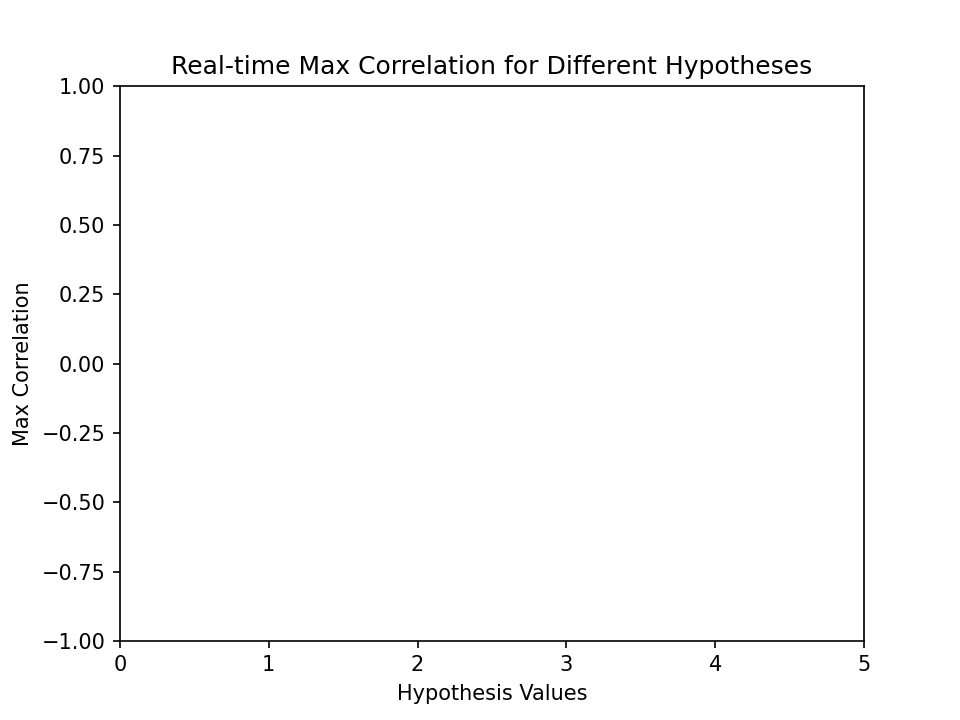

  0%|          | 0/100 [00:00<?, ?it/s]

ValueError: x and y must have the same length.

In [7]:
%matplotlib notebook
from tqdm.notebook import trange
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Assuming filtered_exhaustive_hypotheses, cleaned_avg_entries, and cleaned_subset_traces are loaded

num_hypotheses = len(filtered_exhaustive_hypotheses)
max_correlations = np.zeros(num_hypotheses)

# Initialize plot
plt.ion()
fig, ax = plt.subplots()
ax.set_xlim(min(filtered_exhaustive_hypotheses), max(filtered_exhaustive_hypotheses))
ax.set_ylim(-1, 1)
plt.xlabel('Hypothesis Values')
plt.ylabel('Max Correlation')
plt.title('Real-time Max Correlation for Different Hypotheses')

# Loop over each chunk of data
for chunk_start in trange(0, len(cleaned_avg_entries), 10):
    chunk_end = min(chunk_start + 10, len(cleaned_avg_entries))
    traces_chunk = cleaned_subset_traces[chunk_start:chunk_end]
    entries_chunk = cleaned_avg_entries[chunk_start:chunk_end]

for hw_index, hypothesis in enumerate(filtered_exhaustive_hypotheses):
    hws_chunk = np.array([HW_of_product(entry, hypothesis) for entry in entries_chunk])
    hws_expanded = np.repeat(hws_chunk, len(traces_chunk[0]) // len(hws_chunk))
    
    for trace in traces_chunk:
        corr, _ = pearsonr(trace, hws_expanded)
        max_correlations[hw_index] = max(max_correlations[hw_index], np.abs(corr))

    # Update the plot
    ax.clear()
    ax.plot(filtered_exhaustive_hypotheses, max_correlations)
    plt.draw()
    plt.pause(0.001)

# Best hypothesis index and its correlation
best_hypothesis_index = np.argmax(max_correlations)
best_hypothesis = filtered_exhaustive_hypotheses[best_hypothesis_index]
best_corr = max_correlations[best_hypothesis_index]

print(f"Best Hypothesis: {best_hypothesis}, Correlation: {best_corr}")
